# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import torch

from tqdm import tqdm

import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer

upstream_imputation_path_mac = '/Users/davidharar/Documents/School/thesis/upstream_seq2seq/'
downstream_classification_path_mac = '/Users/davidharar/Documents/School/thesis/downstream_classification'

upstream_imputation_path_linux       = '/home/david/Desktop/projects/thesis/upstream_seq2seq/'
downstream_classification_path_linux = '/home/david/Desktop/projects/thesis/downstream_classification/'

path_linux = '/home/david/Desktop/projects/thesis/'
os.chdir(path_linux)

# get downstream utils
# os.chdir(downstream_classification_path_linux)
# from dataloader.DataLoader import SHL_DataGenerator_for_imputation

from downstream_classification.dataloader.DataGenerator import DataGenerator

# get upstream utils
from upstream_seq2seq.modeling.Transformer import TSTransformerEncoderCNN
import torch


config = {
    # general
    'seed': 123,
    'data_folder_path': './data/processed/',
    # training,
    'batch_size': 32,
    'n_epochs': 30,
    # architecture - to be changed later and pushed out towards tuning,
    'input_dimension': 12,
    'output_dimension': 12,              
    'hidden_dimmension':  128,           # d_model (int) – the number of expected features in the input (required)???,
    'attention_heads': 8,               # number of attention heads, if None then d_model//64,
    'encoder_number_of_layers': 8,
    'decoder_number_of_layers': 8,
    'dropout': 0.4,
    'clip': 1,
    'window': 450 ,
    'train_by_sample': 1,
    'positional_encodings': False,
    'n_iters':  None,                      # plot intermediate results on validation every <n_iters> steps,
    'model_type': "encoder_cnn",
    'saving_path': './models/transformer_cnn_4heads',
    'plot_saving_path': './plots/transformer_cnn_4heads',
    'scrutiny_probs': None,
}



### Get Data

In [2]:
# shl_data_generator = SHL_DataGenerator_for_imputation(
#     metadata_file_path = f'{downstream_classification_path_linux}/data/combined_data/metadata_only_existant_readings_09042023.csv',
#     data_folder_path = f'{downstream_classification_path_linux}/data/individual-signals/',
#     batch_size=4,
#     fillna=0,
# )
shl_data_generator = DataGenerator(
    data_folder_path='./downstream_classification/data/individual-signals/',
    metadata_file_path='./downstream_classification/data/combined_data/metadata_only_existant_readings_09042023.csv',
    targets=['AF','one_year_until_death'],
    sample='train',
    batch_size=4,
    shuffle=True
)

X,y,signal_names = shl_data_generator.__getitem__(1224)
X,signal_names

(array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.

### Get Model

In [3]:
def get_best_model(folder_path = './upstream_seq2seq/models/', model_name = 'transformer_cnn_4heads'):
    """
    Since that in the upstream stage we save basically every model, it is important to 
    take the one that minimized the loss over the validation set.
    """
    model_files = [x for x in os.listdir(folder_path) if model_name in x and 'loss' not in x]

    # get timestemps
    timestemps = [float(x.replace('transformer_cnn_4heads_', '').replace('.pt','')) for x in model_files if x.endswith('.pt')]
    timestemps.sort()

    # get best model (the last one that has been saved)
    best_model_path = folder_path+model_name+'_'+str(timestemps[-1])+'.pt'
    return best_model_path


In [4]:
input_dimension          = config['input_dimension']
output_dimension         = config['output_dimension']
hidden_dimmension        = config['hidden_dimmension']
attention_heads          = config['attention_heads']
encoder_number_of_layers = config['encoder_number_of_layers']
positional_encodings     = config['positional_encodings']
dropout                  = config['dropout']
clip                     = config['clip']
device                   = 'cuda'

upstream_path = get_best_model(folder_path = '/home/david/Desktop/projects/thesis/upstream_seq2seq/models/', model_name = 'transformer_cnn_4heads')

model = TSTransformerEncoderCNN(input_dimension, output_dimension, 
                            hidden_dimmension, attention_heads, 
                            encoder_number_of_layers, dropout).to(device)


model.load_state_dict(torch.load(upstream_path))
print(model)


Num attention heads: 8
TSTransformerEncoderCNN(
  (project_input): Linear(in_features=12, out_features=128, bias=True)
  (encoder): Linear(in_features=12, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=12, bias=True)
  (dropout1): Dropout(p=0.4, 

/home/david/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Get and Analyze MSE
To ensure maximum flexability, we return 12 MSEs for each of the leads, 12 values for each reading.

In [7]:
def get_MSE(src_, model):
    model.eval()
    # data corruption
    # src_ = data_corruptor.corrupt_a_batch(src_)

    # fix shapes ( -> [length, batch_size, channels])
    src_ = np.float32(np.transpose(src_, axes=(2,0,1)))

    # move to gpu so we can pass through model
    src_ = torch.from_numpy(src_).to(device)

    # choose which signal from the first batch to look at
    # sig_to_plot = np.random.randint(0,src_.shape[0],1)

    with torch.no_grad():
        y_pred = model(src_,None).cpu().numpy()
    
    src_ = src_.cpu().numpy()
    
    src_ = np.transpose(src_, axes=(1,2,0))    
    y_pred = np.transpose(y_pred, axes=(1,2,0))    
    mse = np.mean(src_-y_pred,axis=-1)

    return mse

def get_non_zero_leads(X):
    means = np.mean(X,axis=-1) != 0
    return means

def get_mse_for_batch(mse, zeros_mask):
    return [np.mean(mse[j,:][zeros_mask[j,:]])**2 for j in range(mse.shape[0])]

def get_number_of_empty_leads(X):
    sums = np.sum(np.mean(X,axis=-1) == 0,axis=-1)
    return sums

# One example
X,_, signal_names = shl_data_generator.__getitem__(1)
mse = get_MSE(X,model)
non_zeros_mask = get_non_zero_leads(X)
print('sigmals:', signal_names)
print('MSE:', get_mse_for_batch(mse,non_zeros_mask))



sigmals: [32229, 272091, 534612, 426253]
MSE: [8.747849959637403e-05, 8.754293545909595e-05, 0.001524260289637161, 2.7087059472661462e-05]


In [8]:
def get_MSE(src_, model):
    model.eval()
    # data corruption
    # src_ = data_corruptor.corrupt_a_batch(src_)

    # fix shapes ( -> [length, batch_size, channels])
    src_ = np.float32(np.transpose(src_, axes=(2,0,1)))

    # move to gpu so we can pass through model
    src_ = torch.from_numpy(src_).to(device)

    # choose which signal from the first batch to look at
    # sig_to_plot = np.random.randint(0,src_.shape[0],1)

    with torch.no_grad():
        y_pred = model(src_,None).cpu().numpy()
    
    src_ = src_.cpu().numpy()
    
    src_ = np.transpose(src_, axes=(1,2,0))    
    y_pred = np.transpose(y_pred, axes=(1,2,0))    
    mse = np.mean(src_-y_pred,axis=-1)

    return mse

def get_non_zero_leads(X):
    means = np.mean(X,axis=-1) != 0
    return means

def get_mse_for_batch(mse, zeros_mask):
    return [np.mean(mse[j,:][zeros_mask[j,:]])**2 for j in range(mse.shape[0])]

def get_number_of_empty_leads(X):
    sums = np.sum(np.mean(X,axis=-1) == 0,axis=-1)
    return sums

# One example
X,signal_names = shl_data_generator.__getitem__(1)
mse = get_MSE(X,model)
non_zeros_mask = get_non_zero_leads(X)
print('sigmals:', signal_names)
print('MSE:', get_mse_for_batch(mse,non_zeros_mask))



sigmals: [ 32229 272091 534612 426253]
MSE: [8.748329052199466e-05, 8.756782401795563e-05, 0.0015242053130757327, 2.7093748869458367e-05]


## Run over SHL's Train Data

In [16]:
indices = 0
signals = []
mses = []
Ys = []
empty_leads = []
for j in tqdm(range(shl_data_generator.__len__())):
    # load data
    X,y, signal_names = shl_data_generator.__getitem__(j)
    
    # calculate MSE
    mse = get_MSE(X,model)
    zeros_mask = get_non_zero_leads(X)
    mses_batch = get_mse_for_batch(mse,zeros_mask)
    
    # calc empty leads
    empty_leads_batch = get_number_of_empty_leads(X)

    # store values
    # signals += signal_names.tolist()
    signals += signal_names
    mses += mses_batch
    empty_leads += empty_leads_batch.tolist()
    Ys += y.tolist()

signals_and_MSEs = pd.DataFrame({'signal':signals, 'mse': mses, 'empty_leads': empty_leads})
Ys = pd.DataFrame(np.array(Ys))
Ys.columns = ['AF','one_year_until_death']
# signals_and_MSEs.to_csv(f'./combined_downstream_upstram/summary_stats_and_tables/MSE_on_non_empty_leads_transformer_cnn_4heads.csv')
signals_and_MSEs

100%|██████████| 65649/65649 [08:40<00:00, 126.03it/s]


,signal,mse,empty_leads
0,427805,0.005012,2
1,356921,0.025949,11
2,428248,0.000621,4
3,440621,0.000130,9
4,32229,0.000087,2
...,...,...,...
262591,188859,0.010163,9
262592,429695,0.001062,3
262593,232797,0.000424,9
262594,439207,0.027537,4


In [19]:
signals_and_MSEs = pd.concat([signals_and_MSEs, Ys],
axis = 1)

In [21]:
signals_and_MSEs

,signal,mse,empty_leads,AF,one_year_until_death
0,427805,0.005012,2,1.0,0.0
1,356921,0.025949,11,0.0,0.0
2,428248,0.000621,4,0.0,0.0
3,440621,0.000130,9,1.0,0.0
4,32229,0.000087,2,1.0,0.0
...,...,...,...,...,...
262591,188859,0.010163,9,1.0,0.0
262592,429695,0.001062,3,0.0,0.0
262593,232797,0.000424,9,0.0,0.0
262594,439207,0.027537,4,1.0,0.0


## MSE Boxplot

<AxesSubplot:xlabel='empty_leads', ylabel='mse'>

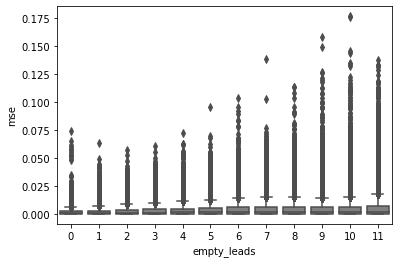

In [20]:
import seaborn as sns
sns.boxplot(data = signals_and_MSEs, x = 'empty_leads', y='mse', color='gray')

<AxesSubplot:xlabel='empty_leads', ylabel='rmse'>

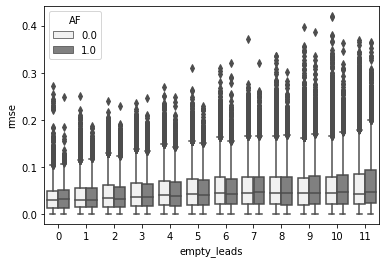

In [26]:
signals_and_MSEs['rmse'] = np.sqrt(signals_and_MSEs['mse'])
import seaborn as sns
sns.boxplot(data = signals_and_MSEs, x = 'empty_leads', y='rmse', color='gray',
            hue = 'AF')

<AxesSubplot:xlabel='empty_leads', ylabel='rmse'>

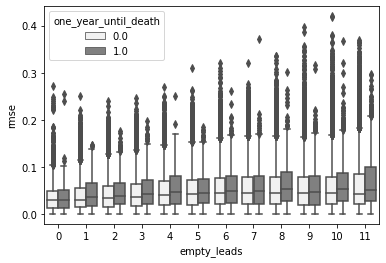

In [27]:
signals_and_MSEs['rmse'] = np.sqrt(signals_and_MSEs['mse'])
import seaborn as sns
sns.boxplot(data = signals_and_MSEs, x = 'empty_leads', y='rmse', color='gray',
            hue = 'one_year_until_death')

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='empty_leads', ylabel='mse'>

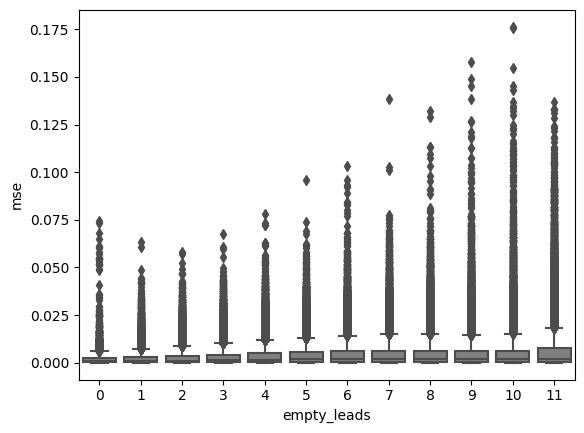

In [16]:
import seaborn as sns
sns.boxplot(data = signals_and_MSEs, x = 'empty_leads', y='mse', color='gray')

# OLD version

<Axes: xlabel='empty_leads', ylabel='mse'>

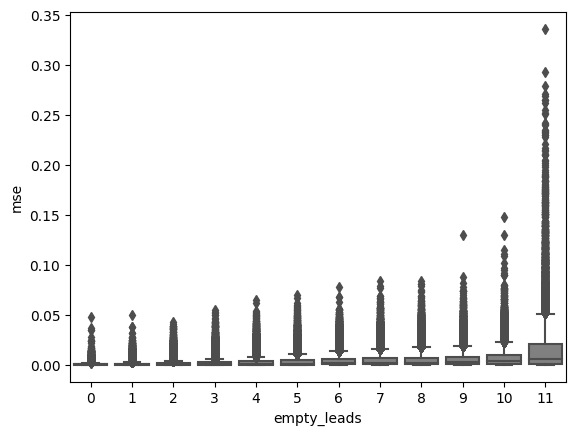

In [160]:
import seaborn as sns
sns.boxplot(data = signals_and_MSEs, x = 'empty_leads', y='mse', color='gray')

# Compare new and Old CSVs
One can see that we have totally different extents. Let's plot the hist of differences

In [35]:
old_signals_and_MSEs = pd.read_csv('/home/david/Desktop/projects/thesis/combined_downstream_upstream/summary_stats_and_tables/MSE_on_non_empty_leads_exp4-base-version-with-train-by-sample-window-450_1695652345.7981088.csv', index_col = 0)


# rename
old_signals_and_MSEs.rename({'mse':'MSE_old'},axis = 1, inplace=True)
signals_and_MSEs_ = signals_and_MSEs.copy()
signals_and_MSEs_ = signals_and_MSEs_[['signal', 'mse', 'AF', 'one_year_until_death']].\
    rename({'mse':'MSE_new'}, axis = 1)

# merge
MSEs = signals_and_MSEs_.merge(old_signals_and_MSEs,
    on = 'signal',
    how = 'outer',
    indicator = True)


print('OLD')
display(old_signals_and_MSEs.iloc[:5])
print('NEW')
display(signals_and_MSEs_.iloc[:5])

print('Merged:')
display(MSEs['_merge'].value_counts())
display(MSEs.iloc[:5])

OLD


,signal,MSE_old,empty_leads
0,427805,0.397876,2
1,356921,0.242064,11
2,428248,0.276720,4
3,440621,0.241417,9
4,32229,0.082282,2


NEW


,signal,MSE_new,AF,one_year_until_death
0,427805,0.005012,1.0,0.0
1,356921,0.025949,0.0,0.0
2,428248,0.000621,0.0,0.0
3,440621,0.000130,1.0,0.0
4,32229,0.000087,1.0,0.0


Merged:


both          262596
right_only    108604
left_only          0
Name: _merge, dtype: int64

,signal,MSE_new,AF,one_year_until_death,MSE_old,empty_leads,_merge
0,427805,0.005012,1.0,0.0,0.397876,2,both
1,356921,0.025949,0.0,0.0,0.242064,11,both
2,428248,0.000621,0.0,0.0,0.276720,4,both
3,440621,0.000130,1.0,0.0,0.241417,9,both
4,32229,0.000087,1.0,0.0,0.082282,2,both


In [36]:
MSEs['RMSE_new'] = np.sqrt(MSEs['MSE_new'])
MSEs['RMSE_old'] = np.sqrt(MSEs['MSE_old'])

In [37]:
MSEs.describe()

,signal,MSE_new,AF,one_year_until_death,MSE_old,empty_leads,RMSE_new,RMSE_old
count,371200.000000,2.625960e+05,262596.000000,262596.000000,364509.000000,371200.000000,2.625960e+05,364509.000000
mean,309970.844801,4.489152e-03,0.251824,0.029486,0.275033,5.999577,5.133773e-02,0.517060
std,152377.381796,7.771905e-03,0.434062,0.169166,0.093105,2.989163,4.305342e-02,0.087646
min,2.000000,4.561783e-14,0.000000,0.000000,0.003204,0.000000,2.135833e-07,0.056600
25%,211430.750000,3.543091e-04,0.000000,0.000000,0.220336,4.000000,1.882310e-02,0.469400
50%,323876.500000,1.655480e-03,0.000000,0.000000,0.262938,6.000000,4.068759e-02,0.512775
75%,437373.250000,5.262928e-03,1.000000,0.000000,0.315100,9.000000,7.254604e-02,0.561338
max,561330.000000,1.762933e-01,1.000000,1.000000,0.895364,11.000000,4.198730e-01,0.946237


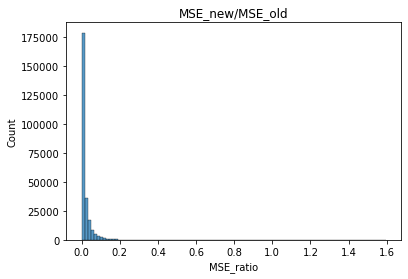

I(MSE_new<MSE_old)


True     257767
False    113433
Name: MSE_ratio, dtype: int64

True     0.694415
False    0.305585
Name: MSE_ratio, dtype: float64

In [41]:
MSEs['MSE_ratio'] = MSEs['MSE_new']/MSEs['MSE_old']
sns.histplot(data = MSEs, x = 'MSE_ratio', bins = 100)
plt.title('MSE_new/MSE_old')
plt.show()
print('I(MSE_new<MSE_old)')
display((MSEs['MSE_ratio']<1).value_counts())
display((MSEs['MSE_ratio']<1).value_counts(normalize=True))

In [42]:
MSEs['RMSE_ratio'] = MSEs['RMSE_new']/MSEs['RMSE_old']

<AxesSubplot:xlabel='empty_leads', ylabel='RMSE_ratio'>

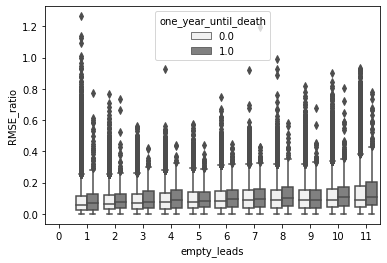

In [45]:
sns.boxplot(data = MSEs, x = 'empty_leads', y='RMSE_ratio', color='gray',
            hue = 'one_year_until_death')

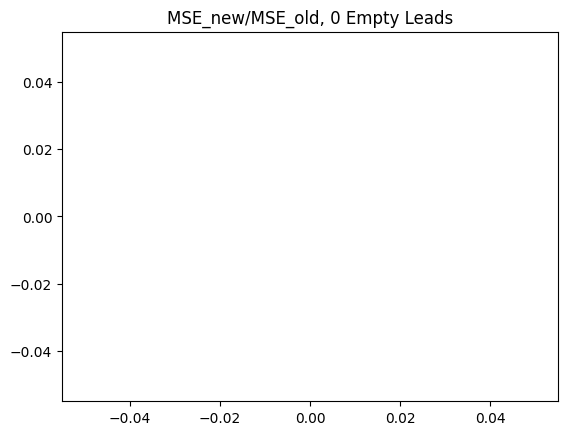

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


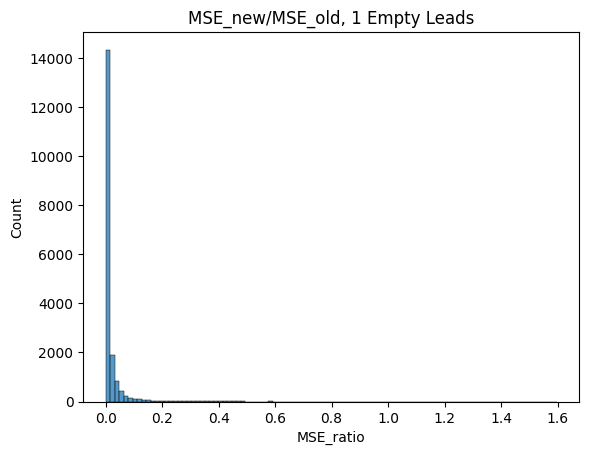

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


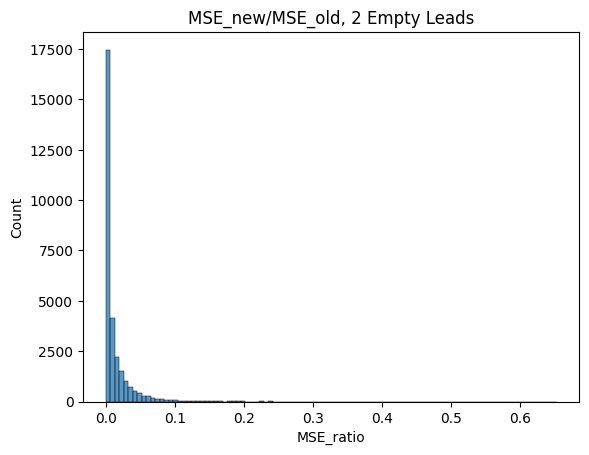

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


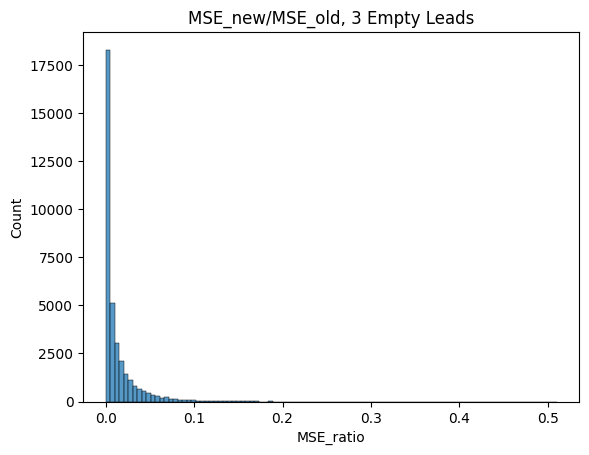

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


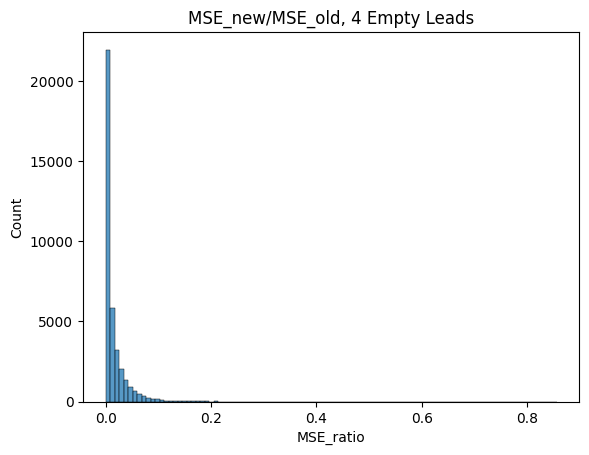

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


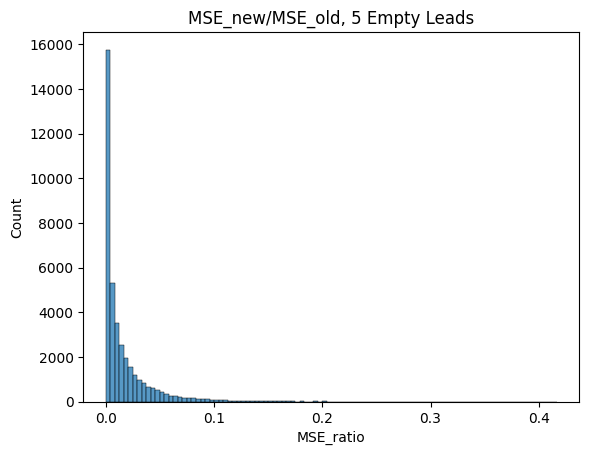

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


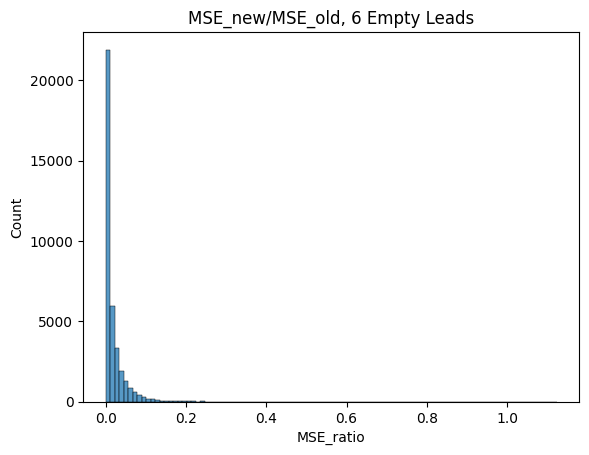

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


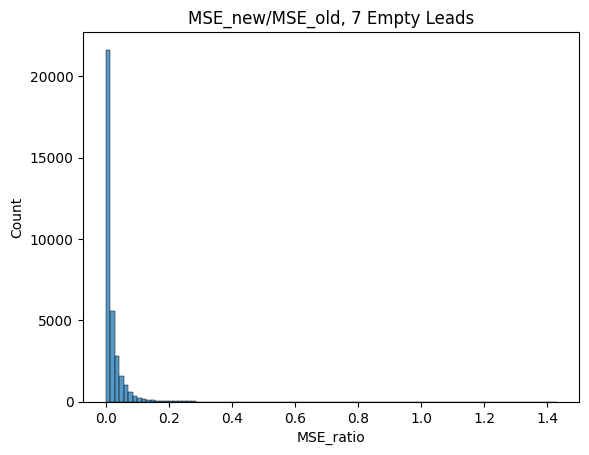

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


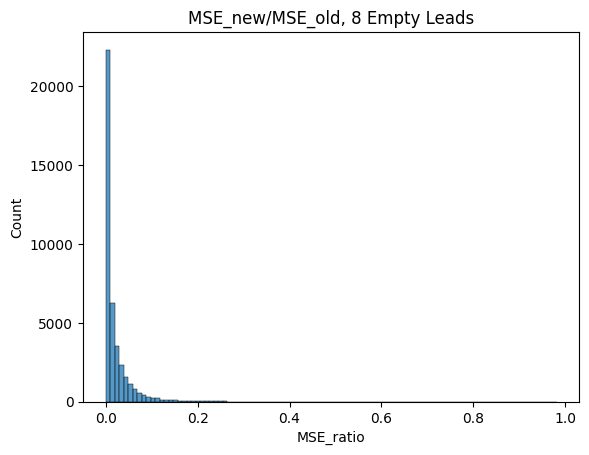

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


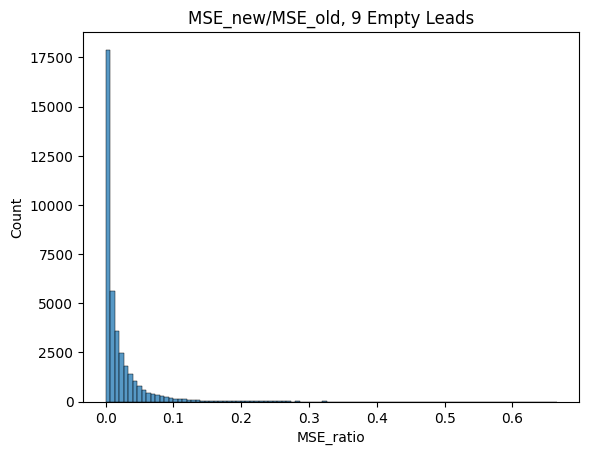

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


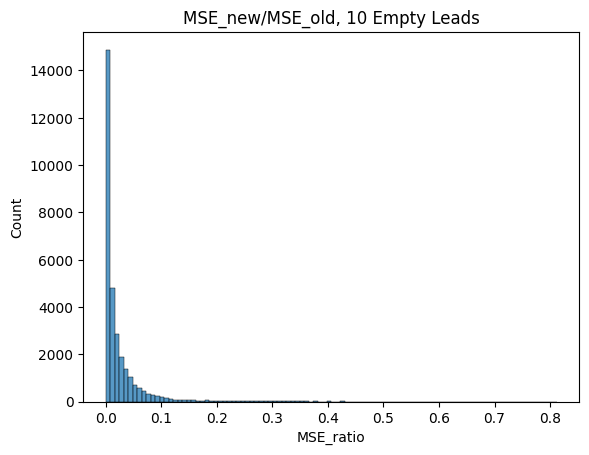

/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/thesis_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


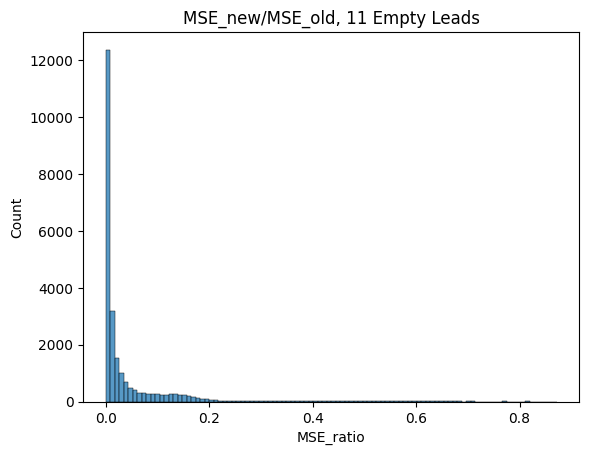

In [37]:
for x in range(12):
    mask = (MSEs['empty_leads'] == x)
    sns.histplot(data = MSEs[mask], x = 'MSE_ratio', bins = 100)
    plt.title(f'MSE_new/MSE_old, {x} Empty Leads')
    plt.show()


# Look qualitatively on best and worst

## NEW

In [46]:
def plot_12_signals_of_three_sources(reading, predicted, plot_saving_path, title=None):
    """
    plot a 12 electrodes reading of before/after. For example, before and after corruption,
    and actutal vs. predicted.
    """
    fig, axs = plt.subplots(6, 2, figsize = (20,20))

    leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']
    s=0
    for ax in axs.flat:
        ax.plot(reading[s])
        ax.plot(predicted[s])
        ax.set_title(leads[s],fontsize=9)
        s+=1
    if title:
        fig.suptitle('Blue-Original; Orange-Predicted' + title)
    else:
        fig.suptitle('Blue-Original; Orange-Predicted')
        
    plt.tight_layout()
    if plot_saving_path:
        plt.savefig(f'{plot_saving_path}.png')
    plt.show()
    
def plot_signal(src_, model, title):
    
    src_ = np.float32(np.transpose(src_, axes=(2,0,1)))

    # move to gpu so we can pass through model
    src_ = torch.from_numpy(src_).to(device)

    # choose which signal from the first batch to look at
    sig_to_plot = 0

    with torch.no_grad():
        y_pred = model(src_,None).cpu().numpy()

    # prep signals for presentation
    corrupted = np.squeeze(src_[:,sig_to_plot,:].cpu().numpy()).T
    reconstructed = np.squeeze(y_pred[:,sig_to_plot,:]).T

    plot_12_signals_of_three_sources(corrupted,reconstructed, None, title)


### 

In [ ]:
for mse_value, signal_index in zip(signals_and_MSEs.sort_values('mse')['mse'][:10].values, \
                                    signals_and_MSEs.sort_values('mse')['signal'][:10].values):
    title_ = f'Signal: {signal_index}, MSE: {mse_value}'
    file_name = f'{signal_index}.npy'
    X = np.load(f'{downstream_classification_path_linux}/data/individual-signals/'+file_name,allow_pickle=True)
    X = np.nan_to_num(X, nan=0)
    X = np.expand_dims(X,0)
    plot_signal(X, model = model, title = title_)

#### Worst 10

In [ ]:
for mse_value, signal_index in zip(signals_and_MSEs.sort_values('mse')['mse'][-10:].values, \
                                    signals_and_MSEs.sort_values('mse')['signal'][-10:].values):
    title_ = f'Signal: {signal_index}, MSE: {mse_value}'
    file_name = f'{signal_index}.npy'
    X = np.load(f'{downstream_classification_path_linux}/data/individual-signals/'+file_name,allow_pickle=True)
    X = np.nan_to_num(X, nan=0)
    X = np.expand_dims(X,0)
    plot_signal(X, model = model, title = title_)

## Random

In [50]:
signals_and_MSEs_shuffled = signals_and_MSEs.sample(frac=1).reset_index(drop=True)

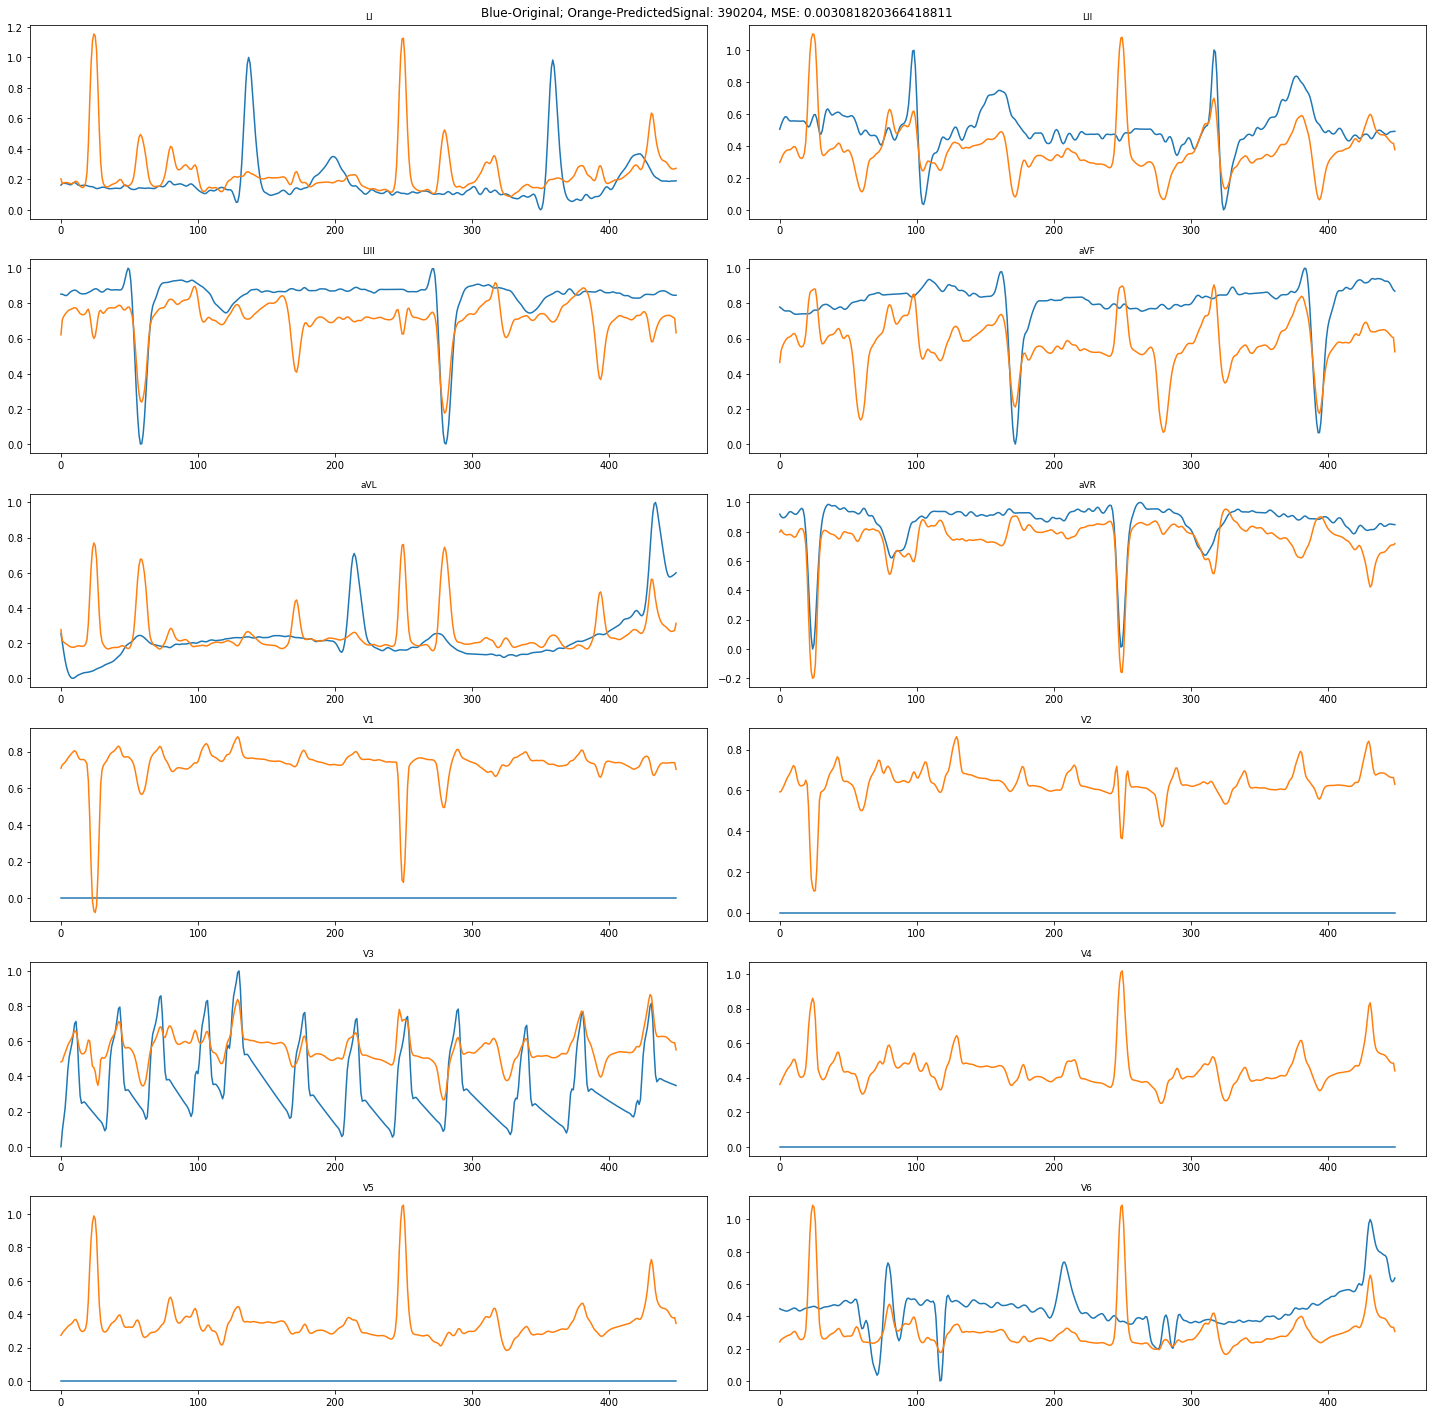

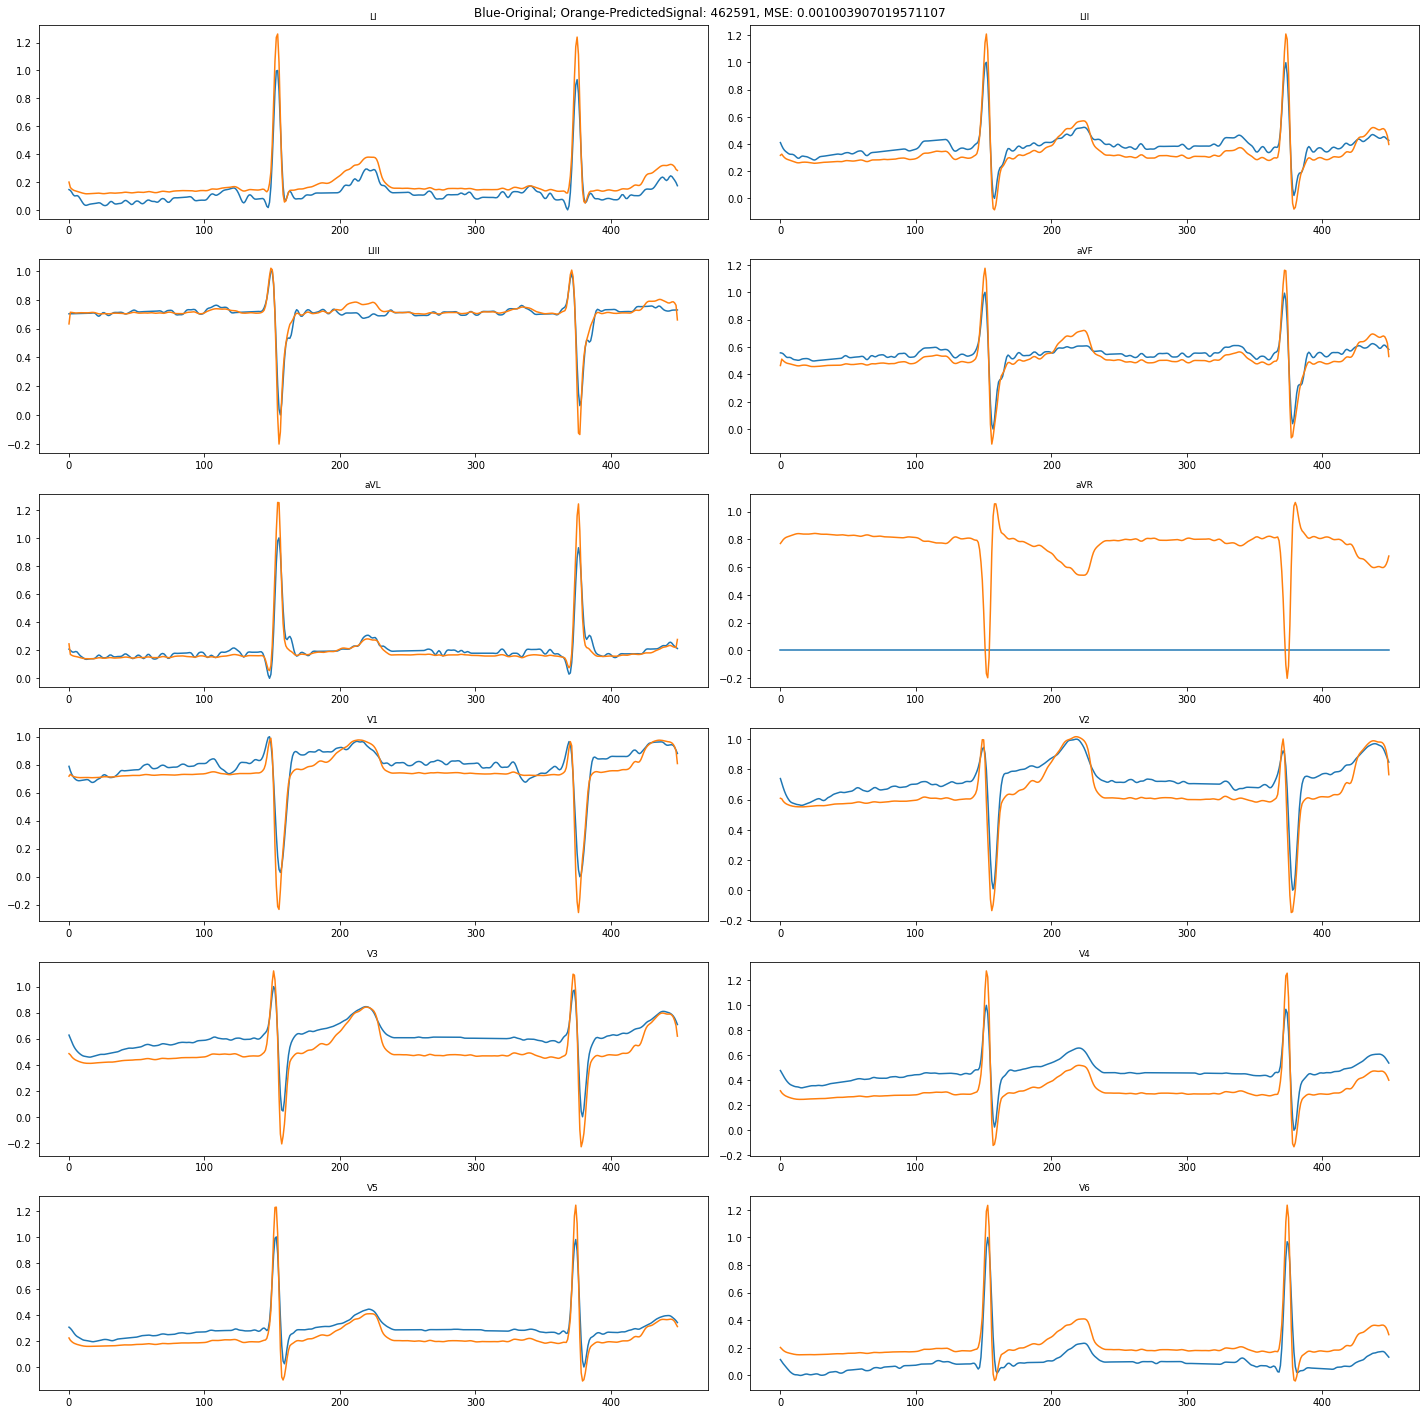

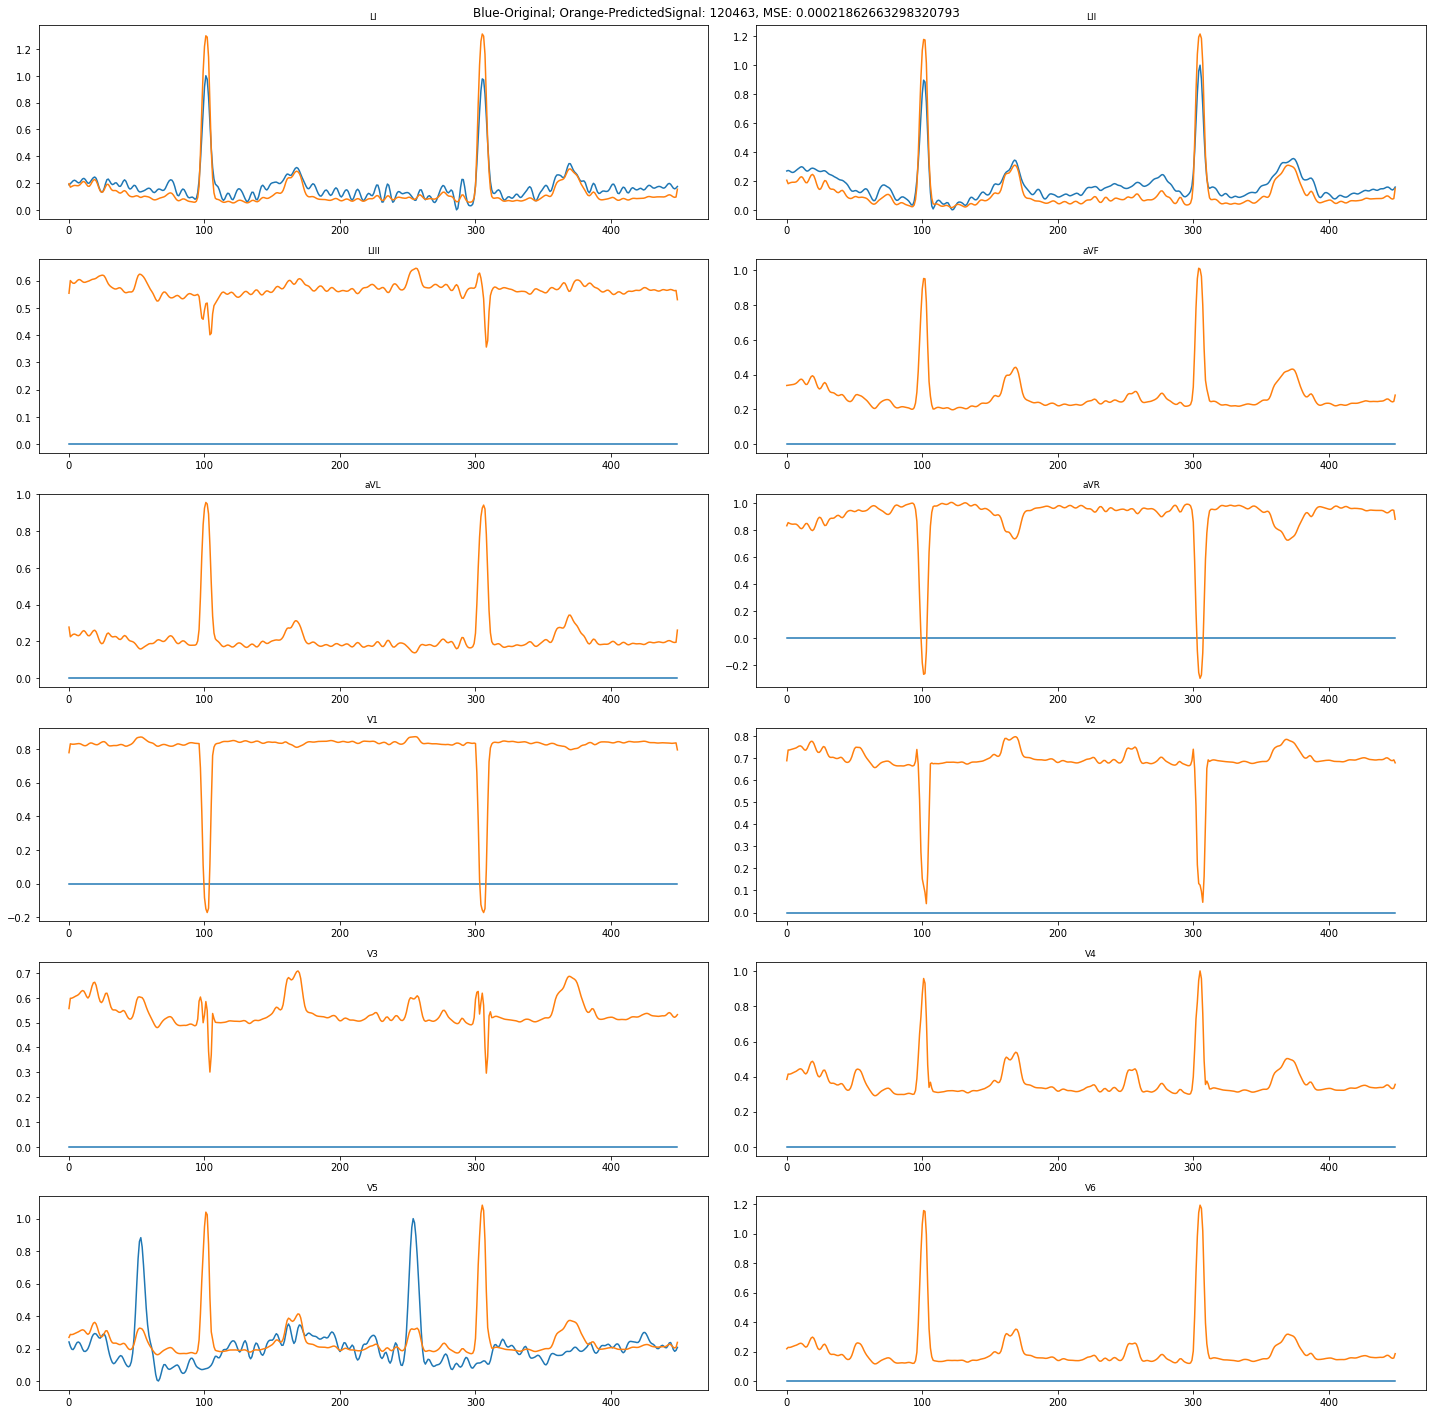

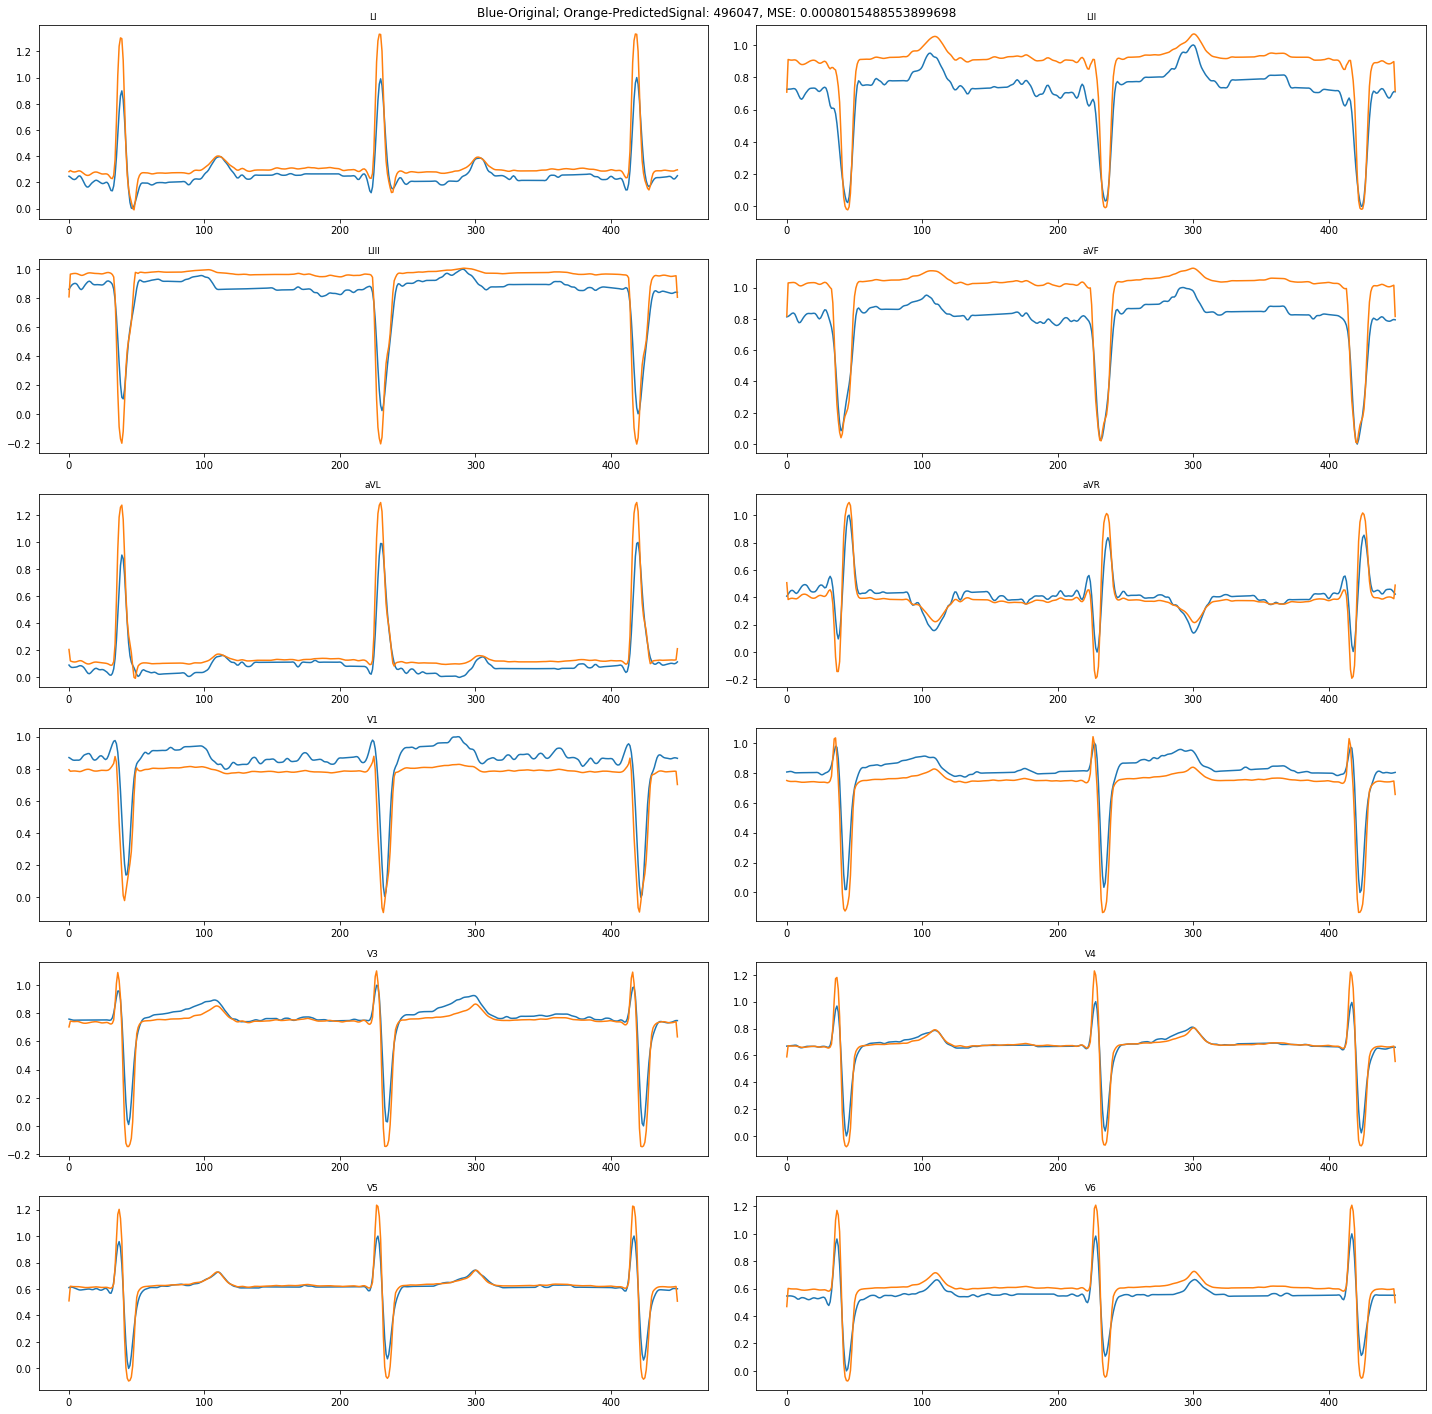

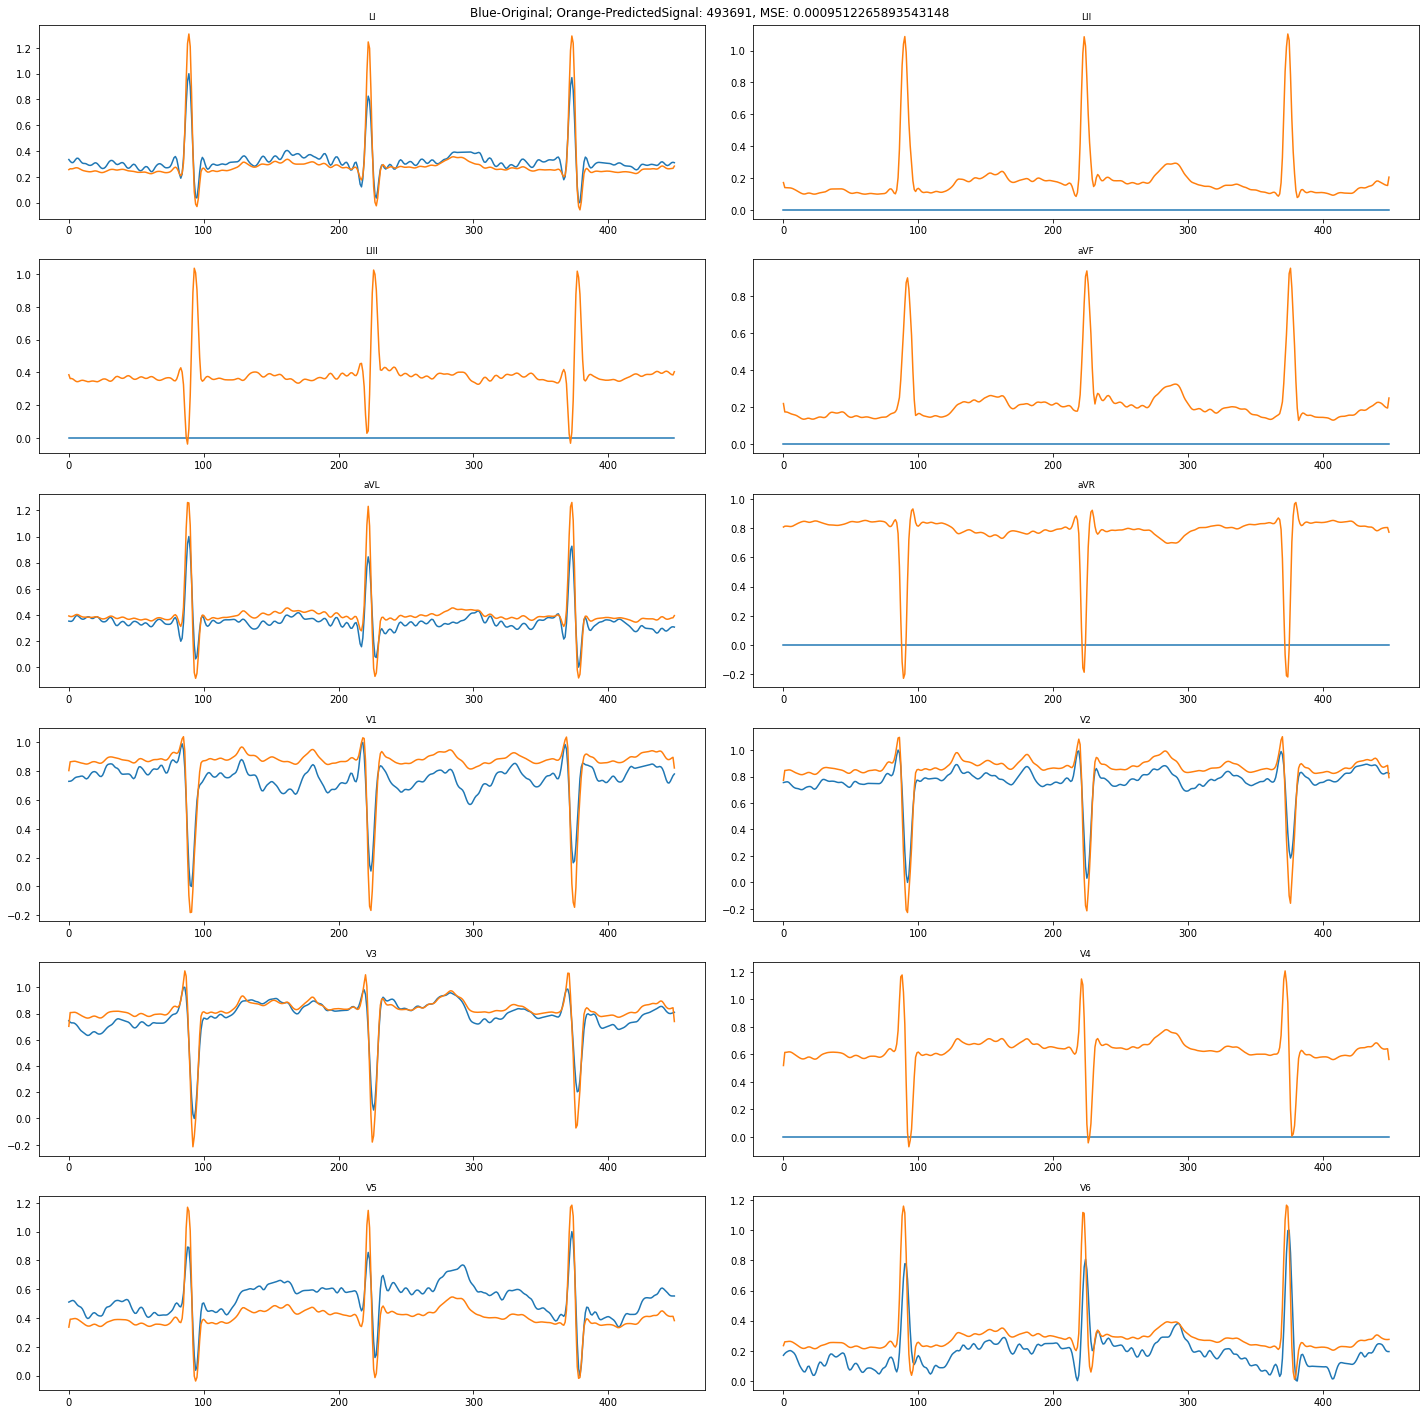

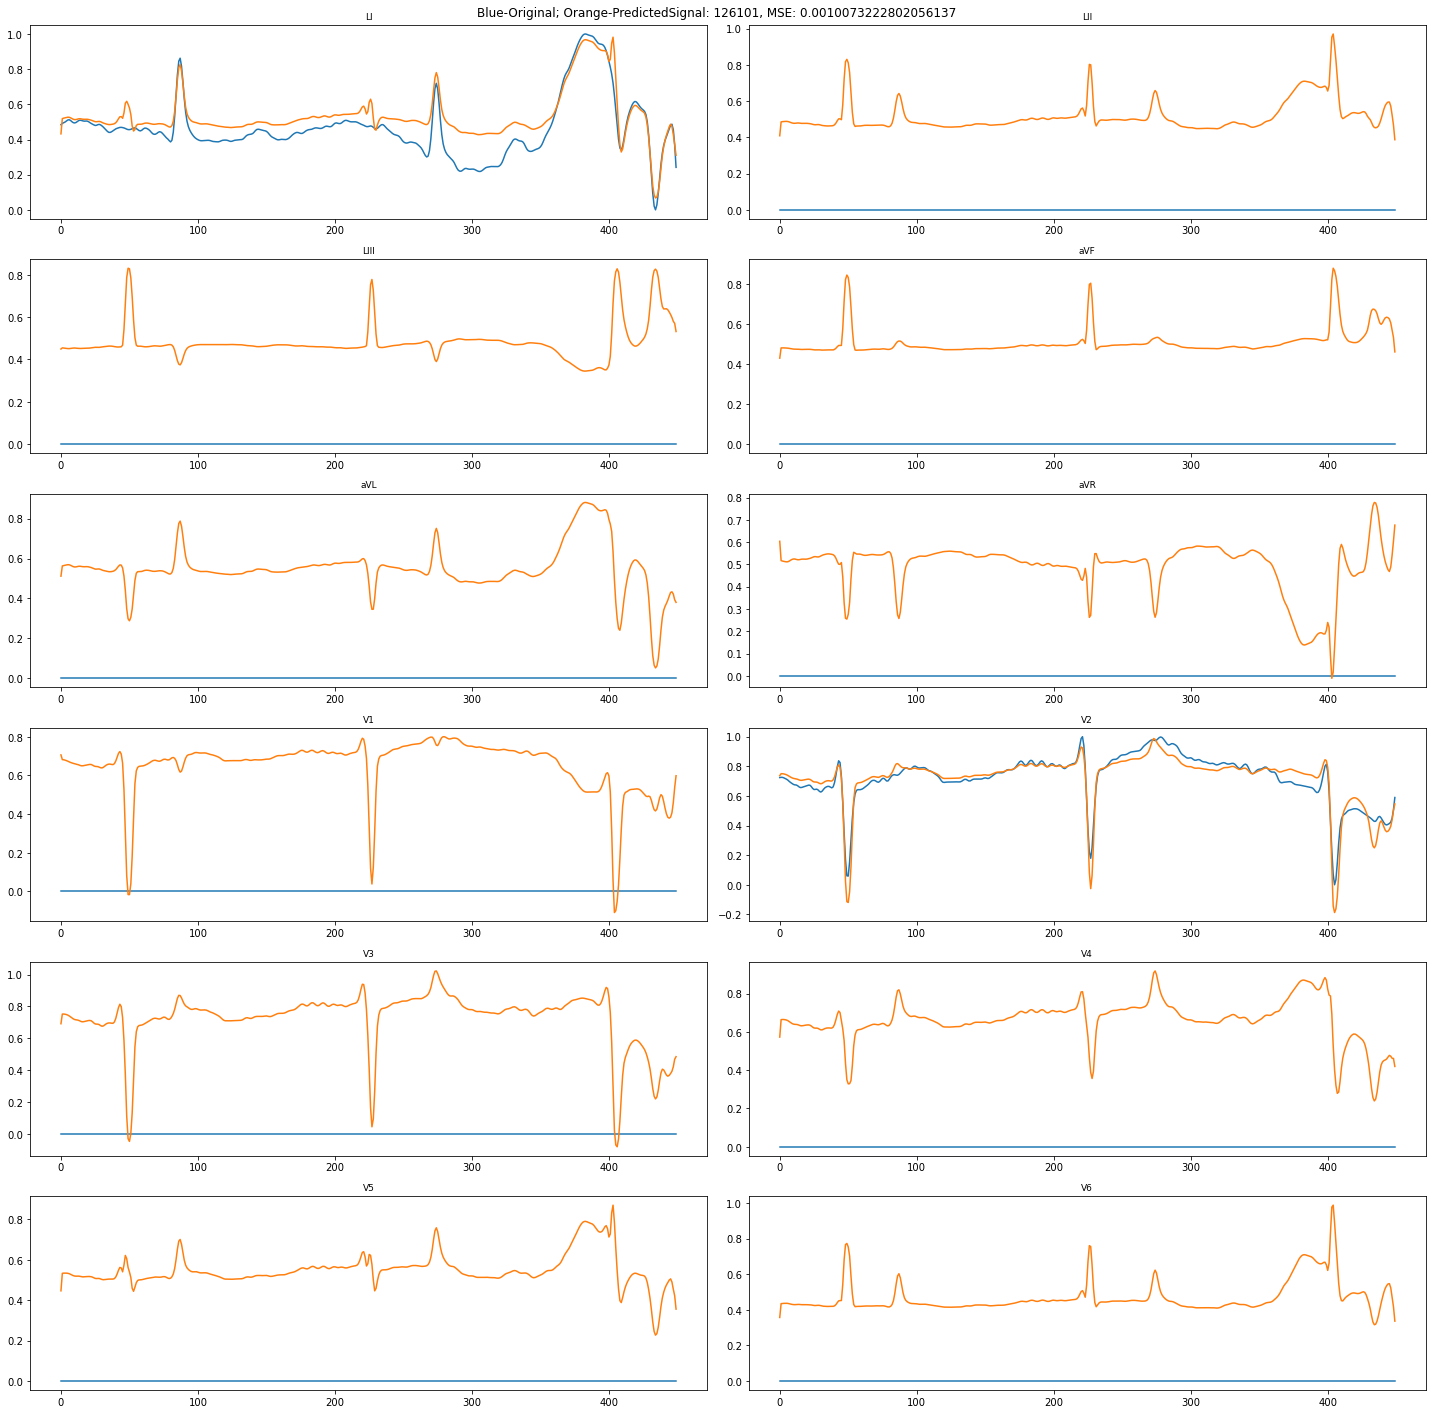

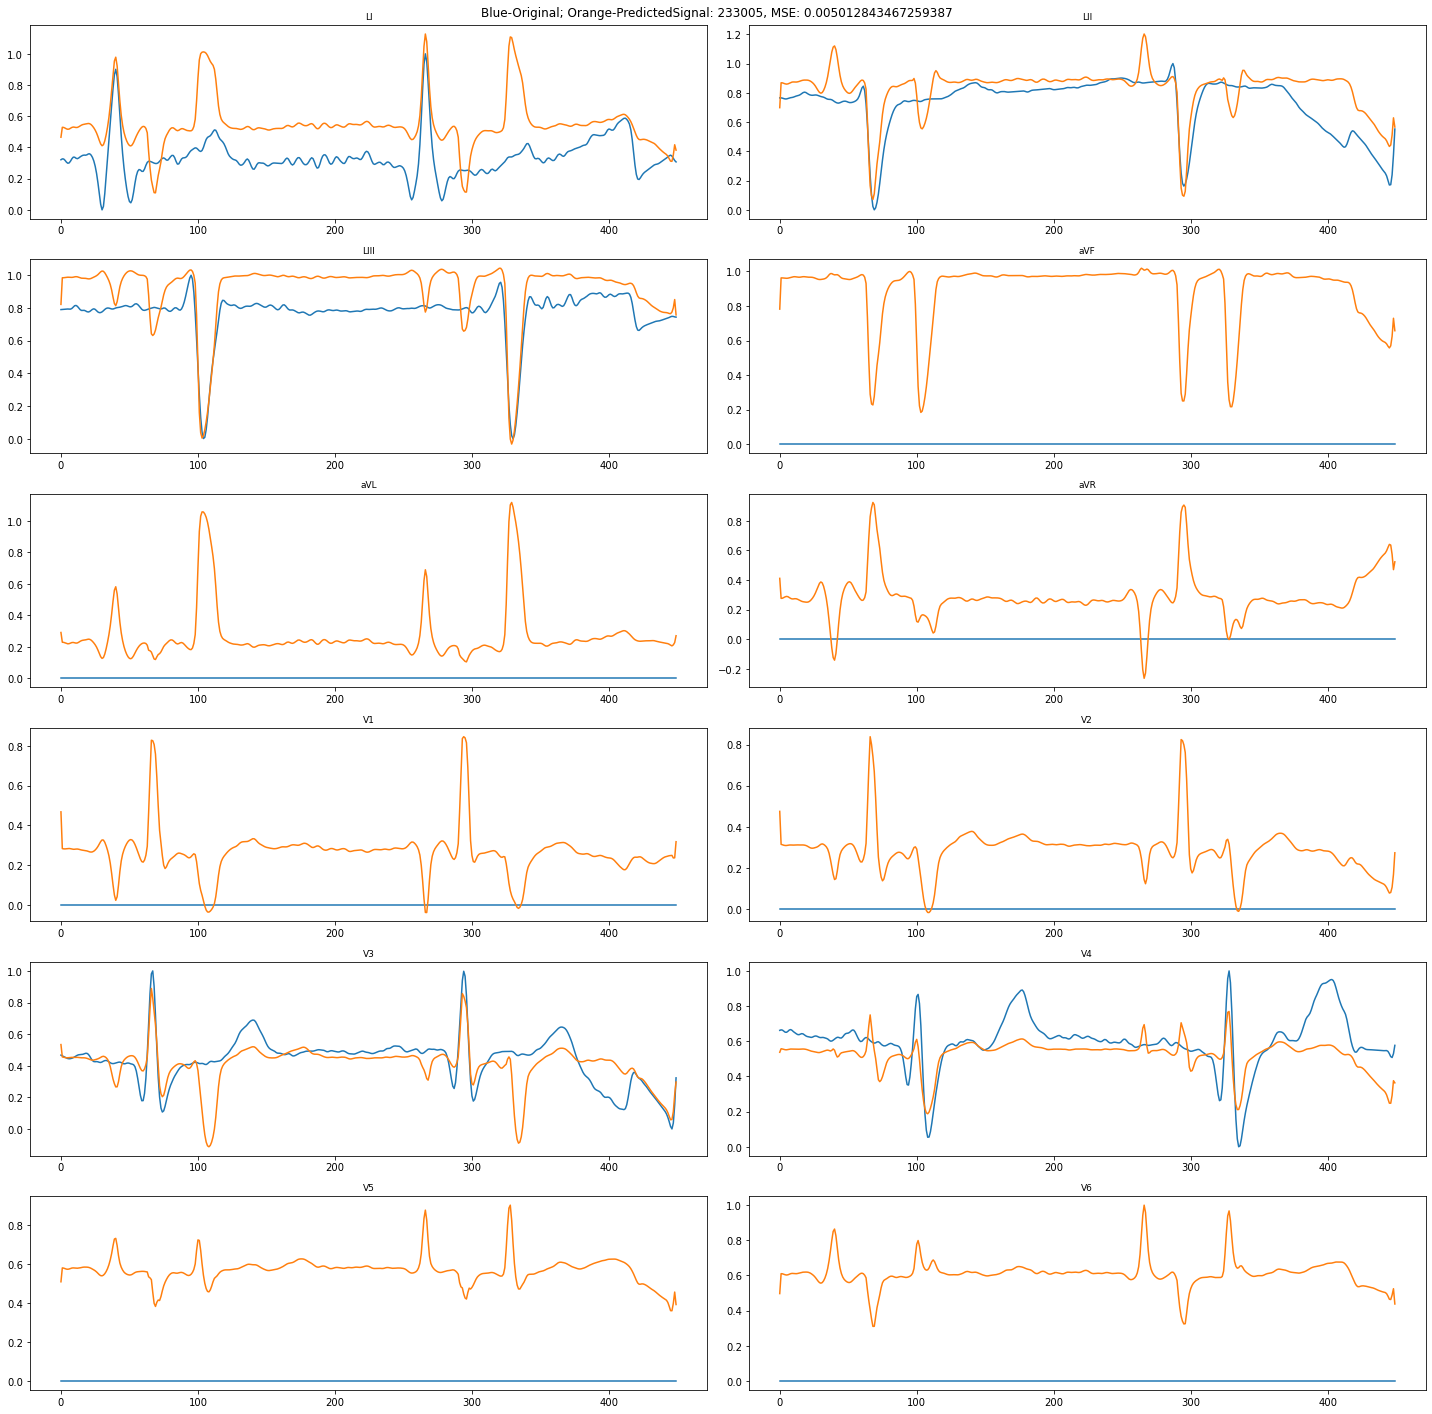

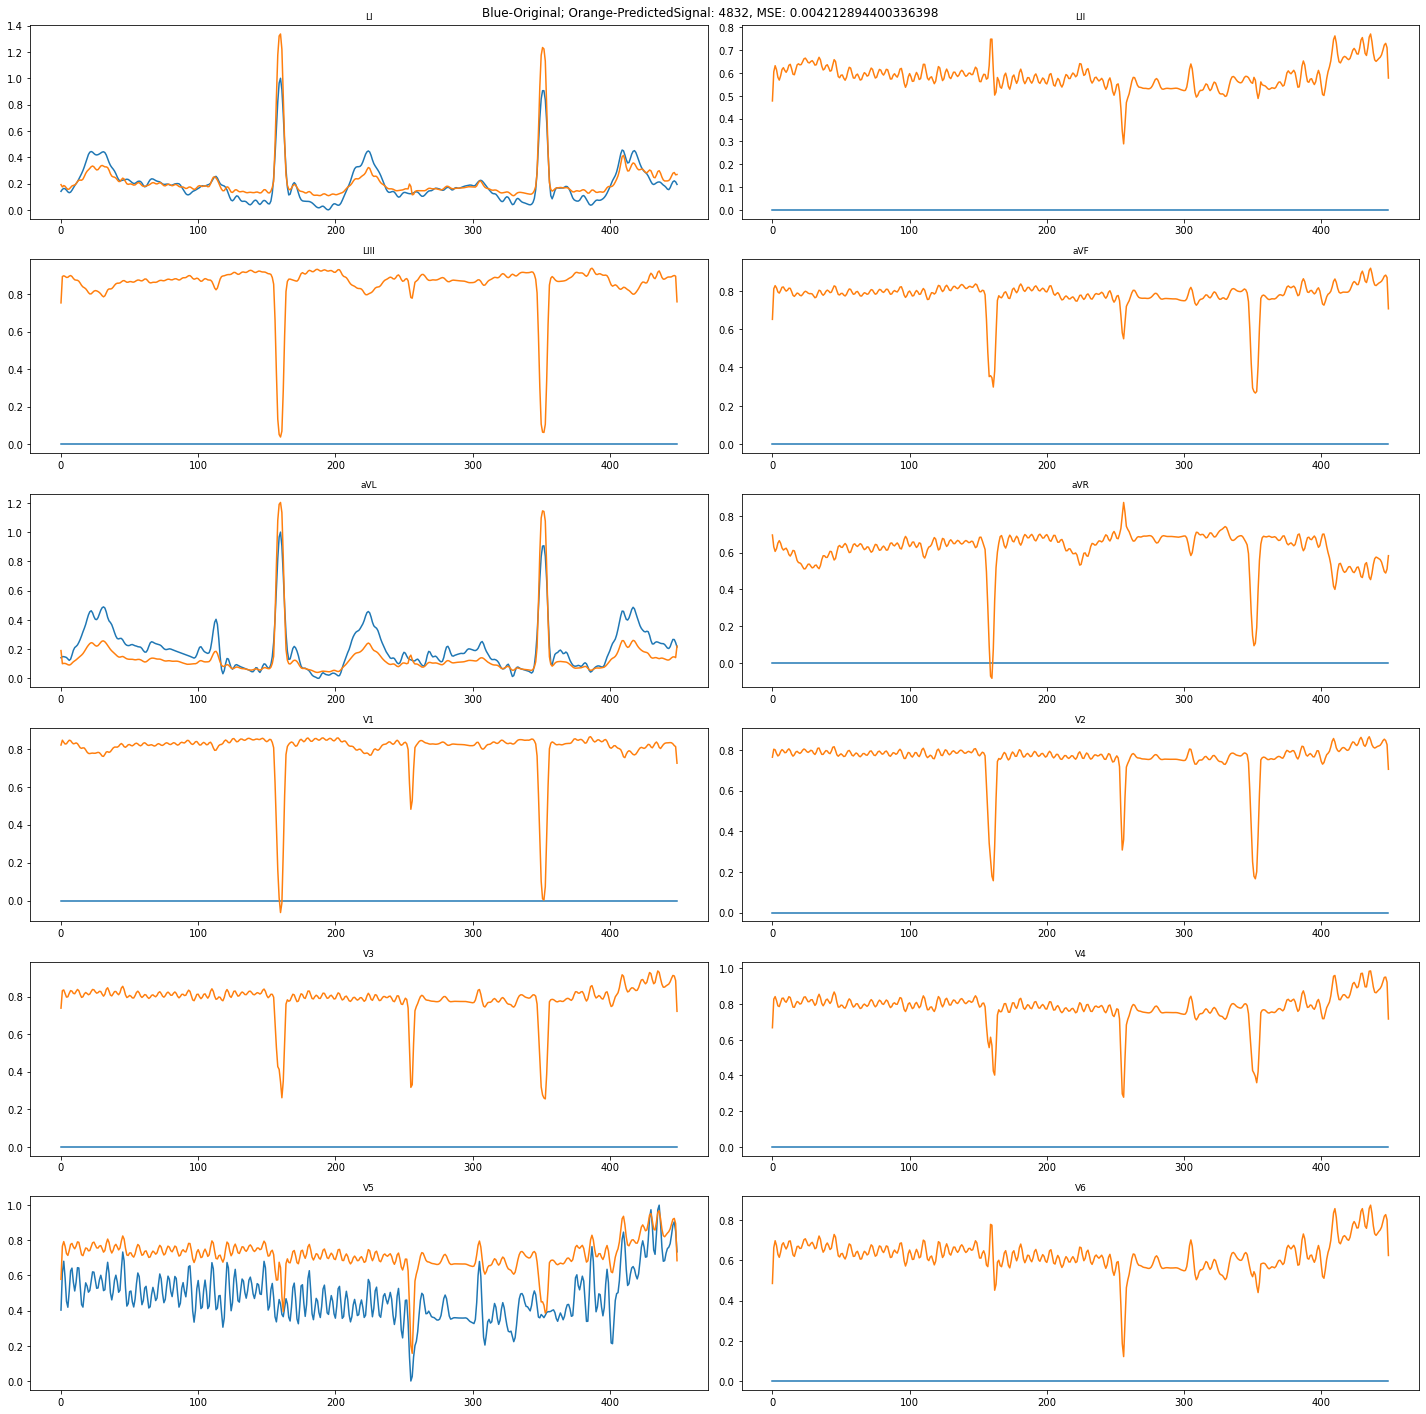

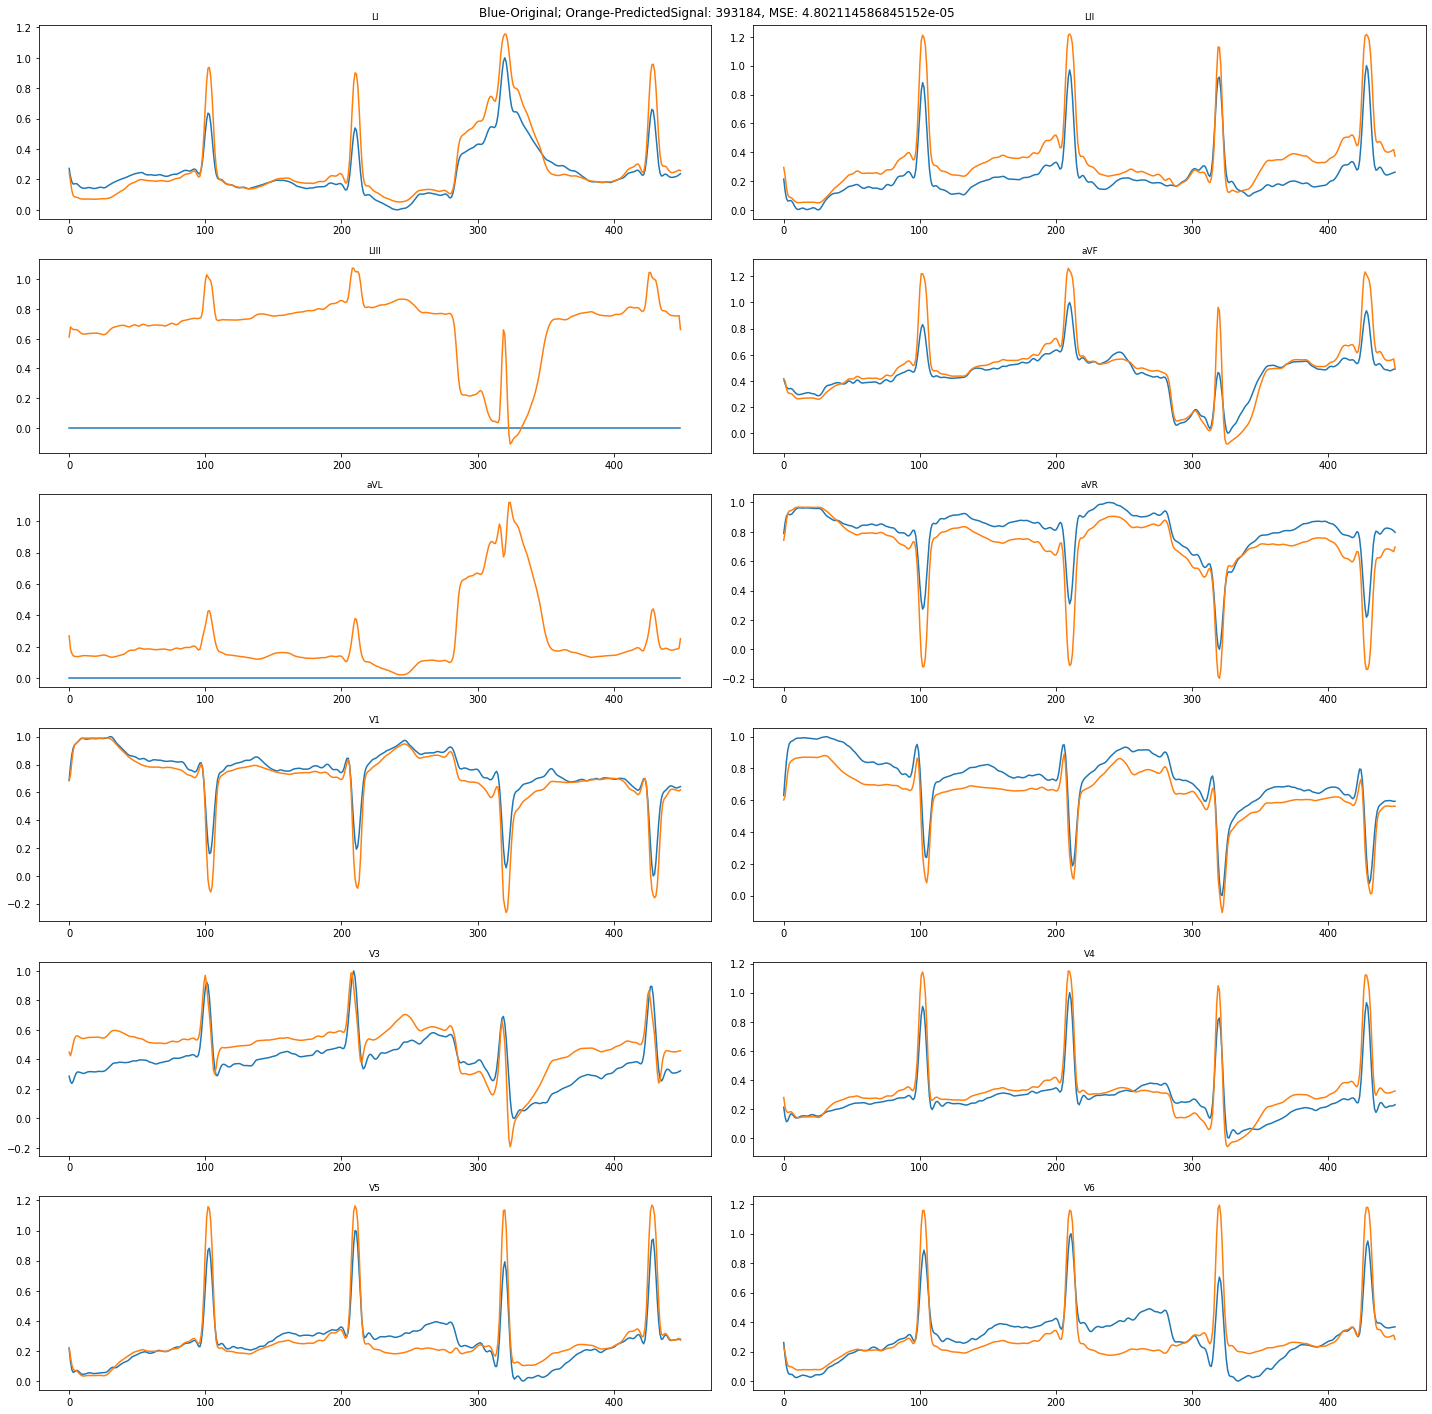

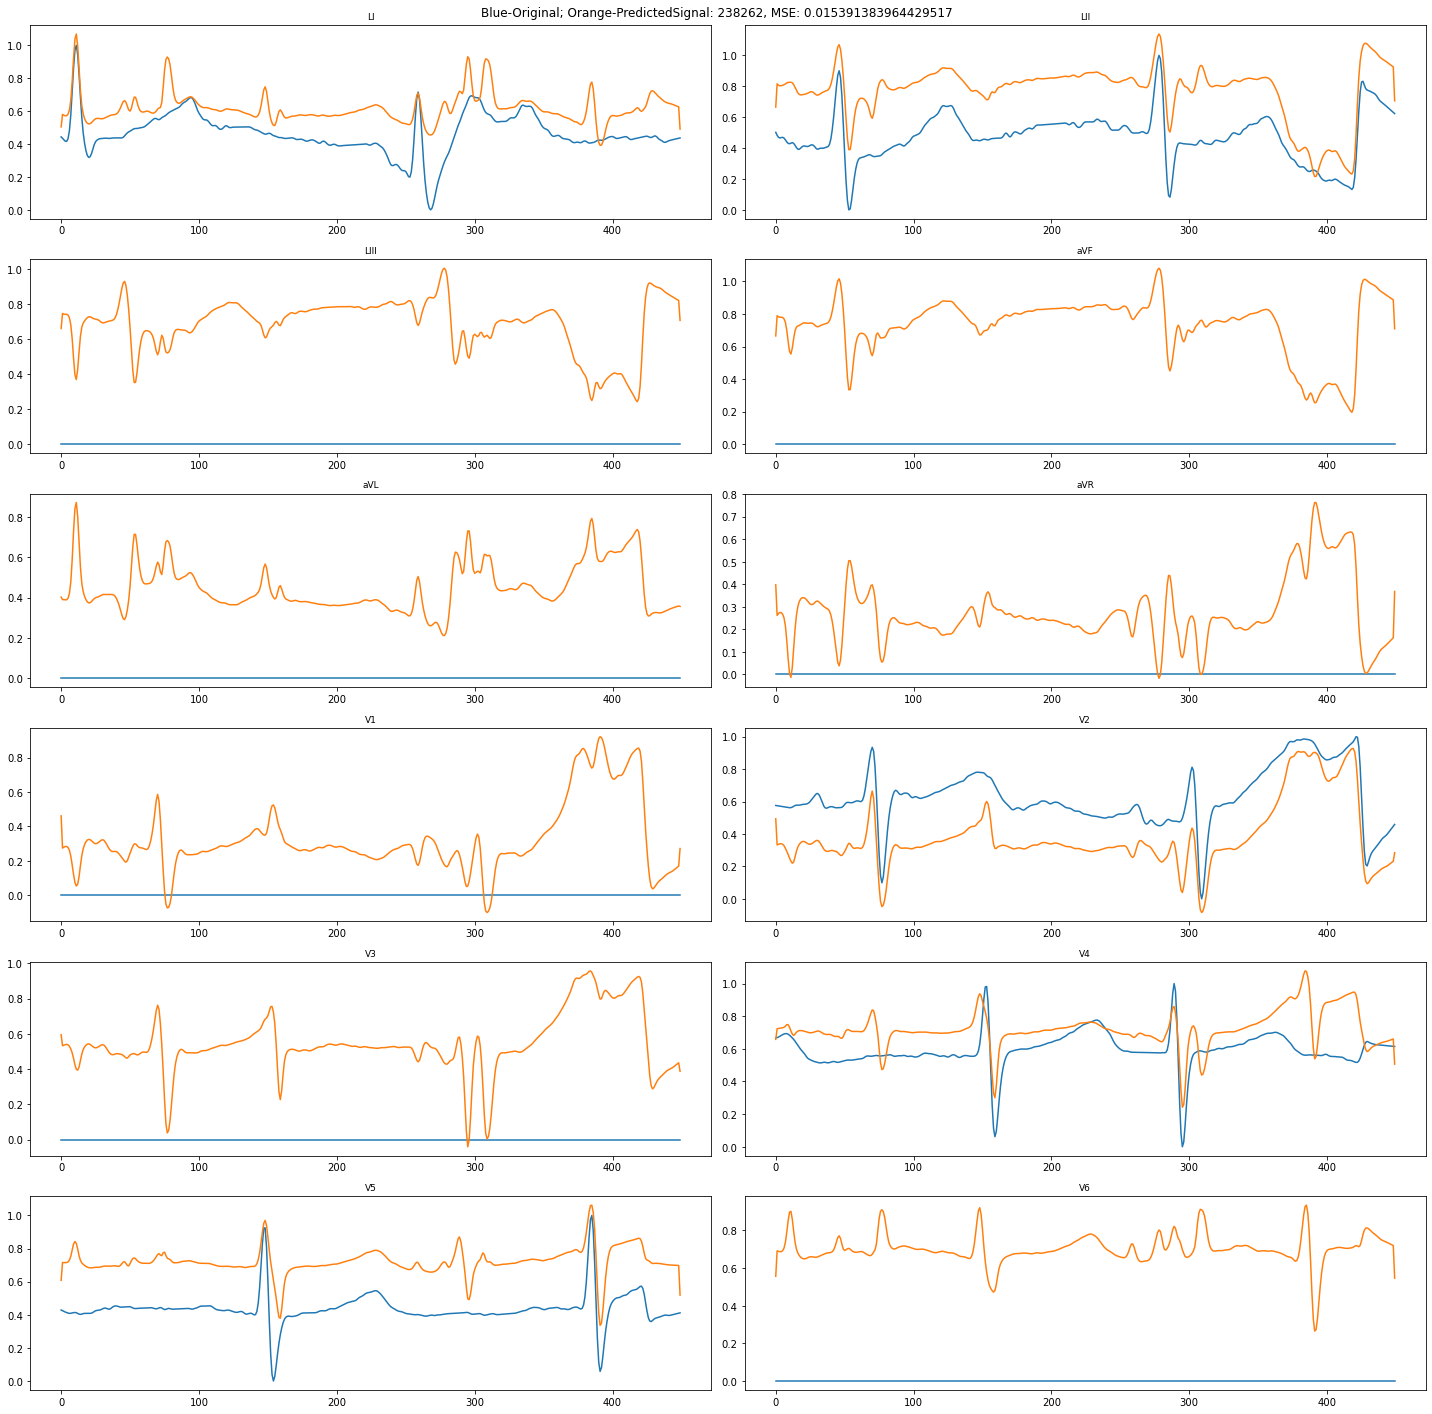

In [51]:
for mse_value, signal_index in zip(signals_and_MSEs_shuffled['mse'][:10].values, \
                                    signals_and_MSEs_shuffled['signal'][:10].values):
    title_ = f'Signal: {signal_index}, MSE: {mse_value}'
    file_name = f'{signal_index}.npy'
    X = np.load(f'{downstream_classification_path_linux}/data/individual-signals/'+file_name,allow_pickle=True)
    X = np.nan_to_num(X, nan=0)
    X = np.expand_dims(X,0)
    plot_signal(X, model = model, title = title_)

## OLD

In [163]:
signals_and_MSEs.sort_values('mse')['signal'][:10]

252520    235857
132710    442154
361426    389759
92863     201389
253594    402529
258947    274703
184256    508080
162380    458520
24530     103531
131645    544529
Name: signal, dtype: int64

In [ ]:
for signal_index in signals_and_MSEs.sort_values('mse')['signal'][:10].values:
    file_name = f'{signal_index}.npy'
    X = np.load(f'{downstream_classification_path}/data/individual-signals/'+file_name,allow_pickle=True)
    X = np.nan_to_num(X, nan=0)
    X = np.expand_dims(X,0)
    plot_signal(X, model_name = 'exp4-base-version-with-train-by-sample-window-450_1695652345.7981088.pt')

### Worst 10

In [ ]:
for signal_index in signals_and_MSEs.sort_values('mse')['signal'][-10:].values:
    file_name = f'{signal_index}.npy'
    X = np.load(f'{downstream_classification_path}/data/individual-signals/'+file_name,allow_pickle=True)
    X = np.nan_to_num(X, nan=0)
    X = np.expand_dims(X,0)
    plot_signal(X, model_name = 'exp4-base-version-with-train-by-sample-window-450_1695652345.7981088.pt')

## Bad but not the worst

In [ ]:
for signal_index in signals_and_MSEs.sort_values('mse')['signal'][-250:-240].values:
    file_name = f'{signal_index}.npy'
    X = np.load(f'{downstream_classification_path}/data/individual-signals/'+file_name,allow_pickle=True)
    X = np.nan_to_num(X, nan=0)
    X = np.expand_dims(X,0)
    plot_signal(X, model_name = 'exp4-base-version-with-train-by-sample-window-450_1695652345.7981088.pt')

In [174]:
signals_and_MSEs.sort_values('mse')['signal'][-250:240]

Series([], Name: signal, dtype: int64)